In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import seaborn as sns

In [ ]:
ticker = 'TECHM.NS'

In [ ]:
df = yf.download(ticker, start = '2019-01-01', end = '2023-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data = df['Close']

In [ ]:
data

,Close
Date,
2019-01-01,719.099976
2019-01-02,712.049988
2019-01-03,691.250000
2019-01-04,681.099976
2019-01-07,687.500000
...,...
2023-12-22,1275.150024
2023-12-26,1282.000000
2023-12-27,1280.150024


In [ ]:
print(data.isnull().sum())

0


In [ ]:
#checking for stationarity
from statsmodels.tsa.stattools import adfuller


# Perform ADF test on the time series (e.g., closing prices)
result = adfuller(data)

# Print the ADF test statistic and p-value
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.2406393943966962
p-value: 0.6558740410469743


in the stationarity check the p value is grater than 0.05. so the data is non stationary. so making it stationary by first differencing

In [ ]:
# First differencing
diff_data = data.diff().dropna()

# Check stationarity again after differencing
result_diff = adfuller(diff_data)
print(f"ADF Statistic (after differencing): {result_diff[0]}")
print(f"p-value: {result_diff[1]}")

ADF Statistic (after differencing): -25.871472130568353
p-value: 0.0


now the data is stationary. then plotting the acf and pacf

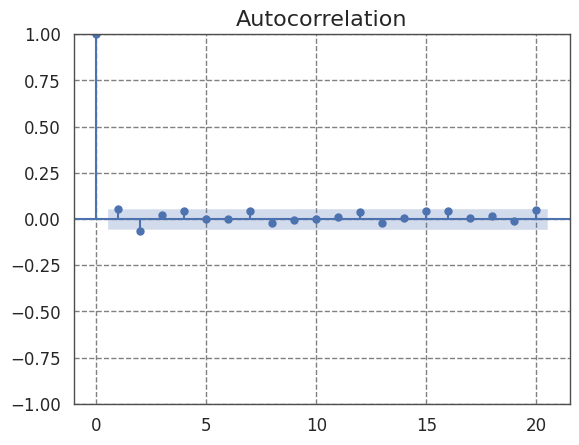

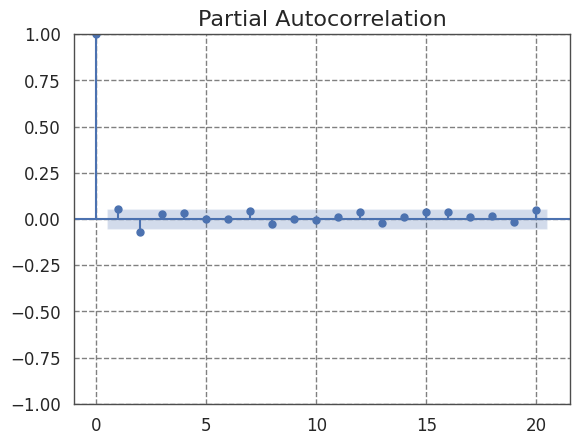

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(diff_data, lags=20)
plot_pacf(diff_data, lags=20)
plt.show()

In the ACF and PACF plots there are no significant spikes after the first spike. so the values can be p=1,q=1

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with determined (p,d,q) order
model = ARIMA(diff_data, order=(1,0,1))
arima_result = model.fit()

# Print summary of the model
print(arima_result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1234
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5393.941
Date:                Sun, 06 Oct 2024   AIC                          10795.882
Time:                        16:21:21   BIC                          10816.354
Sample:                             0   HQIC                         10803.583
                               - 1234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4477      0.571      0.784      0.433      -0.672       1.567
ar.L1         -0.5273      0.187     -2.823      0.005      -0.893      -0.161
ma.L1          0.5953      0.180      3.309      0.0

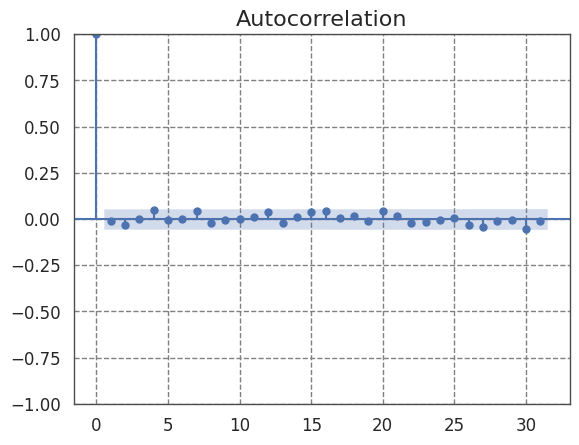

In [ ]:
# Plot ACF of residuals to check for autocorrelation
residuals = arima_result.resid
plot_acf(residuals)
plt.show()


there is no significant spikes in the residuals which means the residuals do not have an auto correlation

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_test)


     lb_stat  lb_pvalue
10  7.473884   0.680077


above, the p value is greater than 0.05. which means the data became stationary

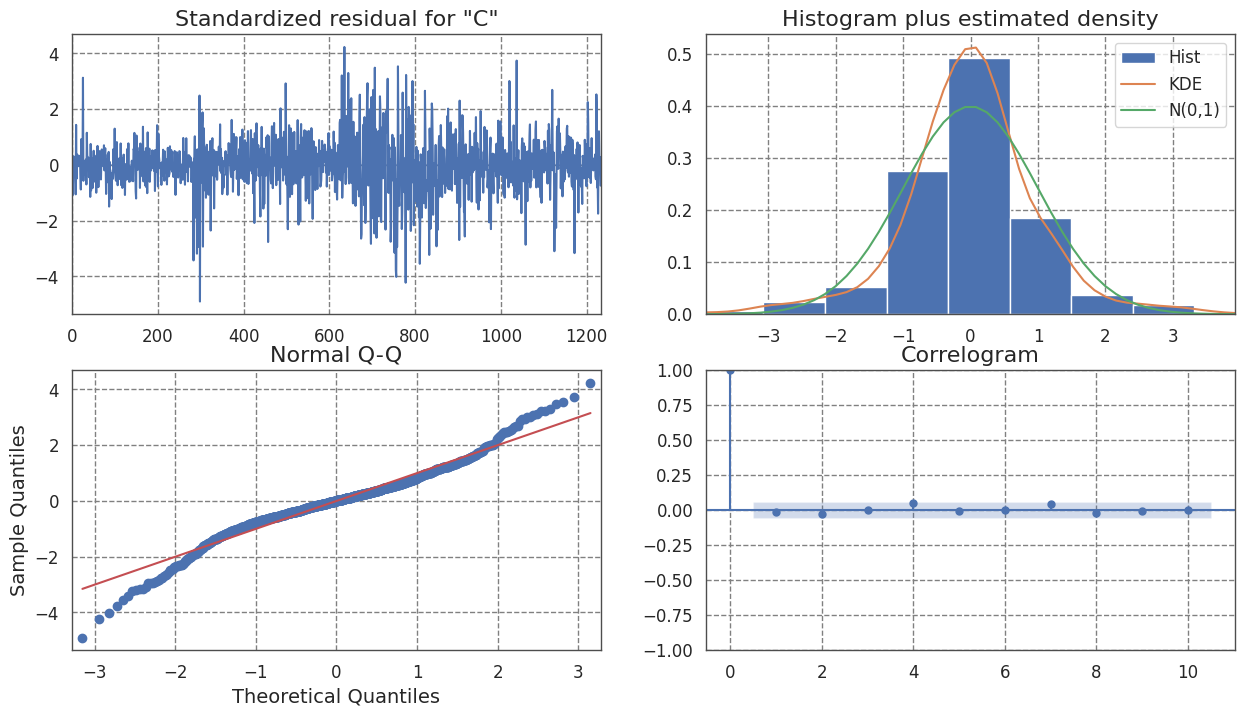

In [ ]:
# Plot residuals to check for white noise
arima_result.plot_diagnostics(figsize=(15, 8))
plt.show()


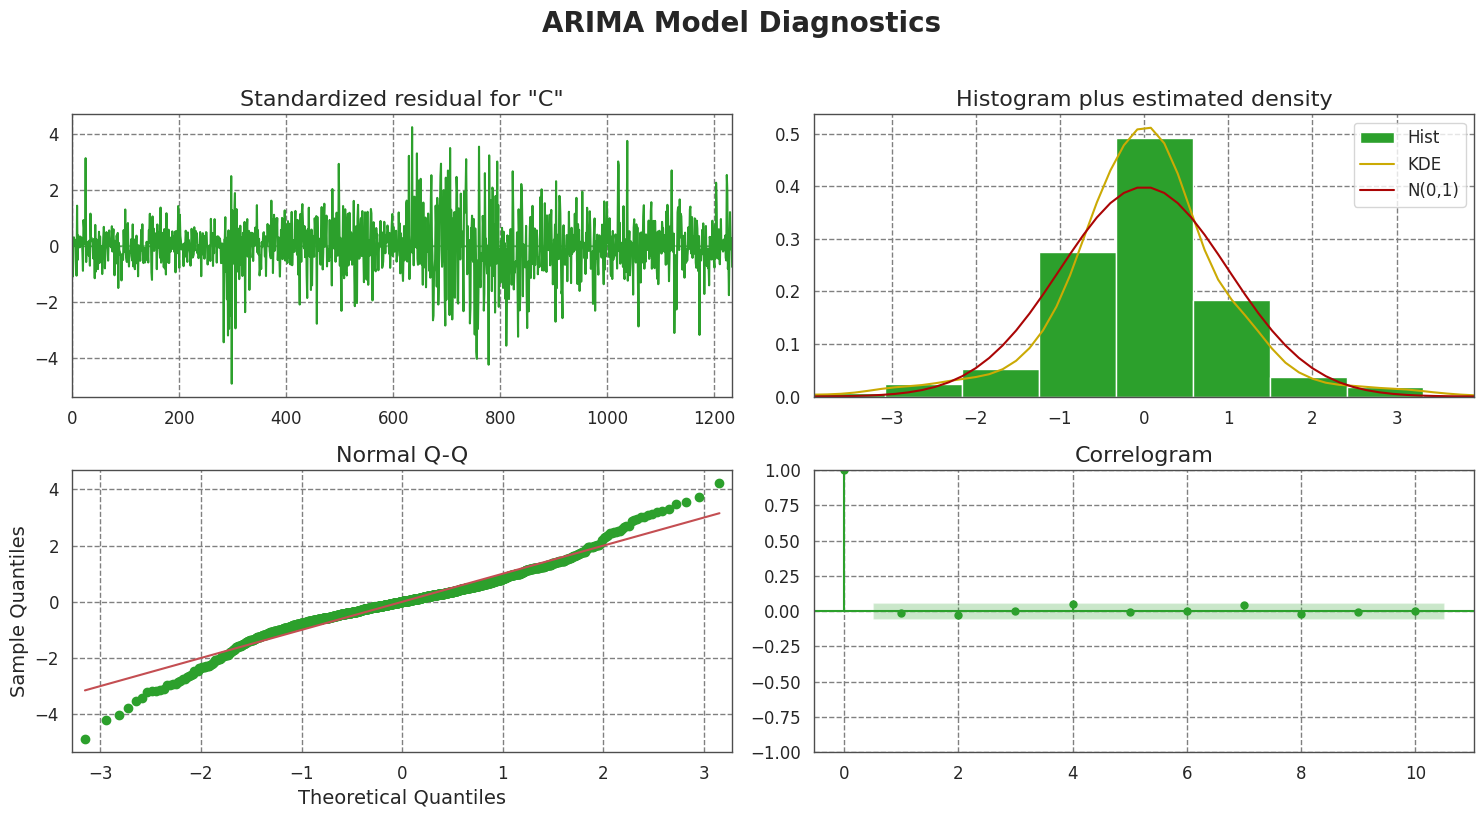

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern and minimalistic style for the plots
sns.set_theme(style="whitegrid", rc={"grid.color": "gray", "grid.linestyle": "--", "axes.edgecolor": "0.3", "axes.linewidth": 1})

# Change the default color cycle to a modern color palette (e.g., teal, purple, etc.)
custom_palette = ["#2ca02c", "#cbaa04", "#aa0505", "#17becf"]  # Teal, Orange, Purple, Cyan
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_palette)

# Adjust font sizes for titles and labels
plt.rcParams.update({
    "axes.titlesize": 16,       # Title size
    "axes.labelsize": 14,       # Axis labels size
    "xtick.labelsize": 12,      # X-axis tick labels size
    "ytick.labelsize": 12,      # Y-axis tick labels size
    "legend.fontsize": 12,      # Legend font size
    "figure.titlesize": 18,     # Overall figure title size
})

# Customize the figure for ARIMA diagnostics with new colors
arima_result.plot_diagnostics(figsize=(15, 8))

# Add an overall title
plt.suptitle('ARIMA Model Diagnostics', fontsize=20, fontweight='bold', y=1.02)

# Show the plot
plt.tight_layout()
plt.show()

the plots indicate that the residuals are normally distributed.

Forecasting for next 20 days

In [ ]:
forecast = arima_result.forecast(steps=20)
print(forecast)

1234   -0.750932
1235    1.079663
1236    0.114443
1237    0.623376
1238    0.355030
1239    0.496521
1240    0.421917
1241    0.461253
1242    0.440512
1243    0.451448
1244    0.445682
1245    0.448723
1246    0.447119
1247    0.447965
1248    0.447519
1249    0.447754
1250    0.447630
1251    0.447695
1252    0.447661
1253    0.447679
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
last_value = data[-1]

<ipython-input-85-705dba17b6e0>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = data[-1]


In [ ]:
last_value

1272.6500244140625

In [ ]:
forecast = pd.Series(forecast)

In [ ]:
forecast

,predicted_mean
1234,-0.750932
1235,1.079663
1236,0.114443
1237,0.623376
1238,0.355030
1239,0.496521
1240,0.421917
1241,0.461253
1242,0.440512
1243,0.451448


In [ ]:
forecasted_original_scale = [last_value + forecast.iloc[0]]

In [ ]:
forecasted_original_scale

[1271.8990927979205]

In [ ]:
# Reverse the differencing by adding the cumulative sum of forecasted differences
for i in range(1, len(forecast)):
    next_value = forecasted_original_scale[-1] + forecast.iloc[i]
    forecasted_original_scale.append(next_value)

In [ ]:
forecasted_original_scale

[1271.8990927979205,
 1272.9787555498583,
 1273.093198227184,
 1273.7165738547467,
 1274.0716036877598,
 1274.5681245863816,
 1274.990041291259,
 1275.4512946546056,
 1275.8918069225545,
 1276.3432553771302,
 1276.788937493157,
 1277.237660034644,
 1277.68477944671,
 1278.1327441430874,
 1278.5802631452136,
 1279.0280171491763,
 1279.4756472433892,
 1279.9233426716705,
 1280.3710036511654,
 1280.8186827945206]

In [ ]:
test_length = len(forecasted_original_scale)

In [ ]:
test_full = yf.download(ticker, start = '2024-01-01', end ='2024-03-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
test_data_full = test_full['Close']

In [ ]:
test_data = test_data_full[:test_length]

In [ ]:
forecasted_original_scale = pd.DataFrame(forecasted_original_scale, columns = ['Predicted'])

In [ ]:
forecasted_original_scale.index = test_data.index[:test_length]

In [ ]:
forecasted_original_scale

,Predicted
Date,
2024-01-01,1271.899093
2024-01-02,1272.978756
2024-01-03,1273.093198
2024-01-04,1273.716574
2024-01-05,1274.071604
2024-01-08,1274.568125
2024-01-09,1274.990041
2024-01-10,1275.451295
2024-01-11,1275.891807


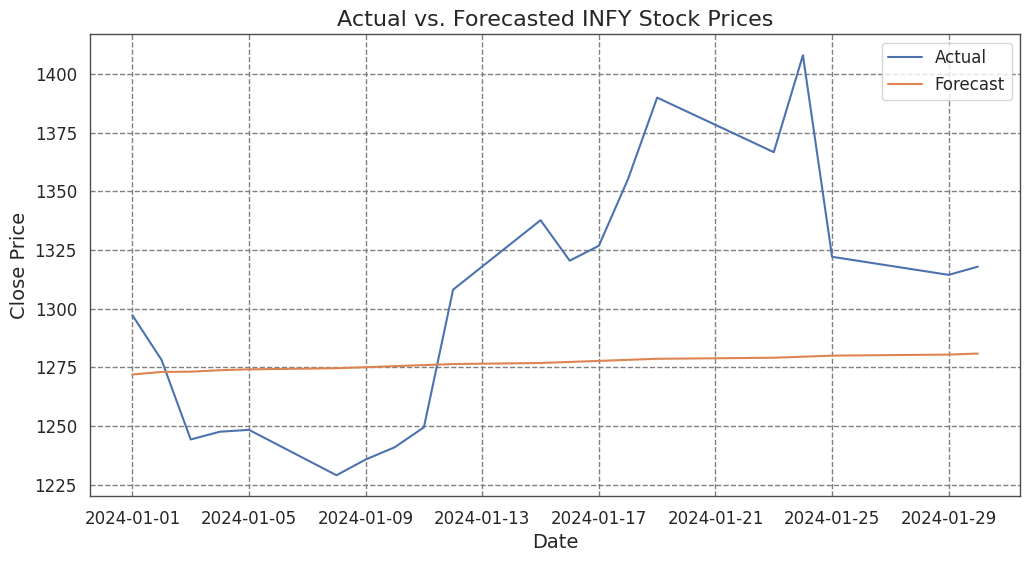

In [ ]:
# prompt: plot the test_data and forecasted_original_scale

plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(forecasted_original_scale, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Forecasted INFY Stock Prices')
plt.legend()
plt.show()
